In [1]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt

In [ ]:
profiles=pd.read_csv('./CTR.txt',sep=':',header=None)
profiles[1]=profiles[1].apply(lambda x: np.array(x.split(';'),dtype=float))
profiles[2]=profiles[2].apply(lambda x: np.array(x.split(';'),dtype=float))
profiles.columns=['num_articles','features','taux_de_clics']

# Random Strategy

In [ ]:
np.random.seed(0)
def random_strategy(data):
    return data['taux_de_clics'].apply(lambda line: np.random.choice(line)).cumsum()

def algo_random(data):
    return data.apply(lambda x : np.random.choice(x)).cumsum()

In [ ]:
np.random.seed(0)
random_strategy(profiles)

In [ ]:
np.random.seed(0)
algo_random(profiles['taux_de_clics'])

# StaticBest

In [ ]:
def staticBest_strategy(data):
    index=np.array(data['taux_de_clics'].tolist()).sum(0).argmax()
    return data['taux_de_clics'].apply(lambda x:x[index]).cumsum().to_numpy()

In [ ]:
staticBest_strategy(profiles)

In [ ]:
def algo_staticBase(data):
    index=np.array(data.tolist()).sum(0).argmax()
    return data.apply(lambda x:x[index]).cumsum().to_numpy()

In [ ]:
algo_staticBase(profiles['taux_de_clics'])

# Stratégie Optimale

In [ ]:
def optimale_strategy(data):
    return data['taux_de_clics'].apply(lambda line: np.max(line)).cumsum().to_numpy()

In [ ]:
optimale_strategy(profiles)

In [ ]:
def algo_optimale(data):
    return data.apply(lambda x : x.max()).cumsum().to_numpy()

In [ ]:
algo_optimale(profiles['taux_de_clics'])

# Put All Together

In [ ]:
plt.plot(profiles['num_articles'],random_strategy(profiles),label='random')
plt.plot(profiles['num_articles'],staticBest_strategy(profiles),label='staticBase')
plt.plot(profiles['num_articles'],optimale_strategy(profiles),label='Optimale')
plt.legend()
plt.show()

In [ ]:
plt.plot(profiles['num_articles'],algo_random(profiles['taux_de_clics']),label='random')
plt.plot(profiles['num_articles'],algo_staticBase(profiles['taux_de_clics']),label='staticBase')
plt.plot(profiles['num_articles'],algo_optimale(profiles['taux_de_clics']),label='Optimale')

# UCB

In [ ]:
def UCB(data):
    T=data.shape[0]
    lenS=len(data['reward'][0])
    cumulated=np.zeros(lenS)
    S=np.ones(lenS)
    res=[0]
    for t in range(1,T+1):
        B=cumulated/S+np.sqrt(2*np.log(t)/S)
        policy=B.argmax()
        S[policy]+=1
        cumulated[policy]+=data['reward'][t-1][policy]
        res.append(res[t-1]+data['reward'][t-1][policy])
    return res[1:]
        
        

In [ ]:
plt.plot(profiles['t'],algo_random(profiles['reward']),label='random')
plt.plot(profiles['t'],algo_staticBase(profiles['reward']),label='staticBase')
plt.plot(profiles['t'],algo_optimale(profiles['reward']),label='Optimale')
plt.plot(profiles['t'],UCB(profiles),label='UCB')
plt.legend()

# UCB

In [ ]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt

# File Reader

In [2]:
def read_ads(filename):
    file=open(filename,'r')
    lines=file.readlines()
    T=[]
    feautures=[]
    taux_clics=[]
    for line in lines: 
        t,features,taux=line.split(':')
        feature=np.array(features.split(';'),dtype=float)
        taux=np.array(taux.split(';'),dtype=float)
        T.append(t)
        feautures.append(feature)
        taux_clics.append(taux)
    return np.array(T,dtype=int),np.array(feautures),np.array(taux_clics)

In [3]:
T,features,taux=read_ads('./CTR.txt')

# BASELINE

In [15]:
#data= only taux
def random_strategy(data):
    return np.cumsum(list(map(lambda x: np.random.choice(x),data)))

def staticBase_strategy(data):
    index=data.sum(0).argmax()
    return np.cumsum(list(map(lambda x: x[index],data)))

def optimale_strategy(data):
    return np.cumsum(list(map(lambda x: x.max(),data)))

In [ ]:
plt.plot(T,random_strategy(taux),label='random')
plt.plot(T,staticBase_strategy(taux),label='staticBase')
plt.plot(T,optimale_strategy(taux),label='Optimale')
plt.legend()

# UCB

In [39]:
#data->taux
def UCB(data):
    T,nbAnnonceur=data.shape
    B=np.zeros(nbAnnonceur)
    S=np.ones(nbAnnonceur)
    cum=np.zeros(nbAnnonceur)
    rewards=[0.]
    for t in range (1,T+1):
        B=(cum/S)+np.sqrt(2*np.log(t)/S)
        pi=B.argmax()
        S[pi]+=1
        reward=data[t-1][pi]
        cum[pi]+=reward
        rewards.append(rewards[t-1]+reward)
    return np.array(rewards[1:])
        

In [40]:
UCB(taux)

array([1.03419057e-01, 1.03419057e-01, 1.03419057e-01, ...,
       1.00670186e+03, 1.00670186e+03, 1.00707176e+03])

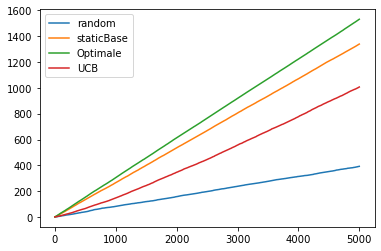

In [25]:
plt.plot(T,random_strategy(taux),label='random')
plt.plot(T,staticBase_strategy(taux),label='staticBase')
plt.plot(T,optimale_strategy(taux),label='Optimale')
plt.plot(T,UCB(taux),label='UCB')
plt.legend()

In [45]:
class UCB(object):
    def __init__(self,taux_de_clics,confidence=1.0):
        self.c=confidence
        self.T,self.nbAnnonceur=taux_de_clics.shape
        self.data=taux_de_clics
        self.t=0
        self.quality = np.zeros((self.nbAnnonceur))
        self.counter = np.ones((self.nbAnnonceur))
        
        
    def act(self):
        self.t += 1
        action = np.argmax(self.quality + self.c * np.sqrt(2 * np.log(self.t) / (self.counter)))
        return action
    
    def learn(self):
        
        rewards=[]
        for t in range(1, self.T + 1):
            action=self.act()
            reward=self.data[t-1][action]
            self.quality[action] += (reward-self.quality[action]) / (self.counter[action])
            self.counter[action] += 1
            rewards.append(reward)
        return np.cumsum(rewards)

In [44]:
UCB(taux).learn()

array([1.03419057e-01, 1.03419057e-01, 1.03419057e-01, ...,
       9.98334452e+02, 9.98334452e+02, 9.98704353e+02])

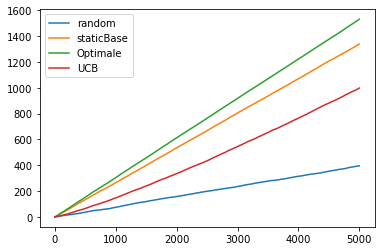

In [23]:
plt.plot(T,random_strategy(taux),label='random')
plt.plot(T,staticBase_strategy(taux),label='staticBase')
plt.plot(T,optimale_strategy(taux),label='Optimale')
plt.plot(T,UCB(taux).learn(),label='UCB')
plt.legend()

# Lin-UCB

In [ ]:
def LinUCB(features,data,alpha=0.1):
    T=len(data)
    nbA=len(data[0])
    dim=len(features[0])
    A=np.array([np.identity(dim) for _ in range(nbA)])
    b=np.zeros((nbA,dim,1)) 
    rewards=[]
    for t in range(T):
        x_t=features[t].reshape((dim,1))
        P=[]
        for a in range(nbA):
            rev_A=np.linalg.inv(A[a])
            theta=np.dot(rev_A,b[a])
            P.append(np.dot(theta.T,x_t)+alpha*np.sqrt((np.dot(np.dot(x_t.T,rev_A),x_t))))
        max_arms=np.argmax(P)
        reward=data[t,max_arms]
        rewards.append(reward)
        A[max_arms]+=np.dot(x_t,x_t.T)
        b[max_arms]+=reward*x_t
    return np.cumsum(rewards)
            

In [ ]:
plt.plot(T,algo_random(taux),label='random')
plt.plot(T,algo_staticBase(taux),label='staticBase')
plt.plot(T,algo_optimale(taux),label='Optimale')
plt.plot(T,UCB(taux),label='UCB')
plt.plot(T,LinUCB(features,taux),label='LinUCB')
plt.legend()

In [ ]:
def LinUCB2(features,data,alpha):
    d = len(features[0])
    l = len(data[0])
    A = {}
    b = {}
    pi = np.zeros((l,1))
    accu = [0]
    for t in range(data.shape[0]):
        x_t=features[t].reshape((d,1))
        for a in range(l):
            if(A.get(a) is None):
                A[a] = np.identity(d)
                b[a] = np.zeros((d,1))
            invA = np.linalg.inv(A[a])
            theta=(invA @ b[a]).T
            pi[a] = theta @ x_t + alpha* np.sqrt((x_t.T @ invA) @ x_t)
        choice = pi.argmax()
        accu.append(accu[t-1]+data[t][choice])
#         print(pi,choice)
        A[choice] += x_t @ x_t.T
        b[choice] += data[t][choice] * x_t
    return accu[1:]

In [ ]:

plt.plot(T,LinUCB(features,taux),label='LinUCB')
plt.plot(T,LinUCB2(features,taux,0.1),label='LinUCB2')


plt.legend()